In [1]:

import instructor
from pydantic import BaseModel, Field
from openai import OpenAI
from enum import Enum
from typing import List
import pandas as pd
import os


In [2]:
# Define the path to the data folder, going up one directory
data_folder = os.path.join('..', 'data')

# Read the datasets into DataFrames
df = pd.read_csv(os.path.join(data_folder, 'Phishing_Email.csv'))

## Email Spam/Phishing Classification


In [3]:
df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


### EDA

In [4]:
df.iloc[-1000:, :]['Email Type'].value_counts()


Email Type
Safe Email        624
Phishing Email    376
Name: count, dtype: int64

In [5]:
# County how many emails are empty on the column Email Text
print(f" {len(df[df['Email Text'].isna()])} Emails out of {len(df)} are Nan")
print("The ratio of empty emails is: ", len(df[df['Email Text'].isna()]) / len(df))

 16 Emails out of 18650 are Nan
The ratio of empty emails is:  0.0008579088471849866


In [6]:
# Make sure that Email Text is a string
df['Email Text'] = df['Email Text'].astype(str)

# County how many emils in Email Text say 'empty'
df[df['Email Text'] == 'empty']
print(f" {df[df['Email Text'] == 'empty'].shape[0]} Emails out of {len(df)} are empty")
print("The ratio of empty emails is: ", df[df['Email Text'] == 'empty'].shape[0] / df.shape[0])

 533 Emails out of 18650 are empty
The ratio of empty emails is:  0.028579088471849867


In [7]:
# Create a column showing the lenght od that email for the strings in the Email Text column
# Since it is a string, count the number of words
# Do another column showing the number of characters

# Number of words
df['Email Length Words'] = df['Email Text'].apply(lambda x: len(x.split()))
# Number of characters
df['Email Length Characters'] = df['Email Text'].apply(lambda x: len(x))



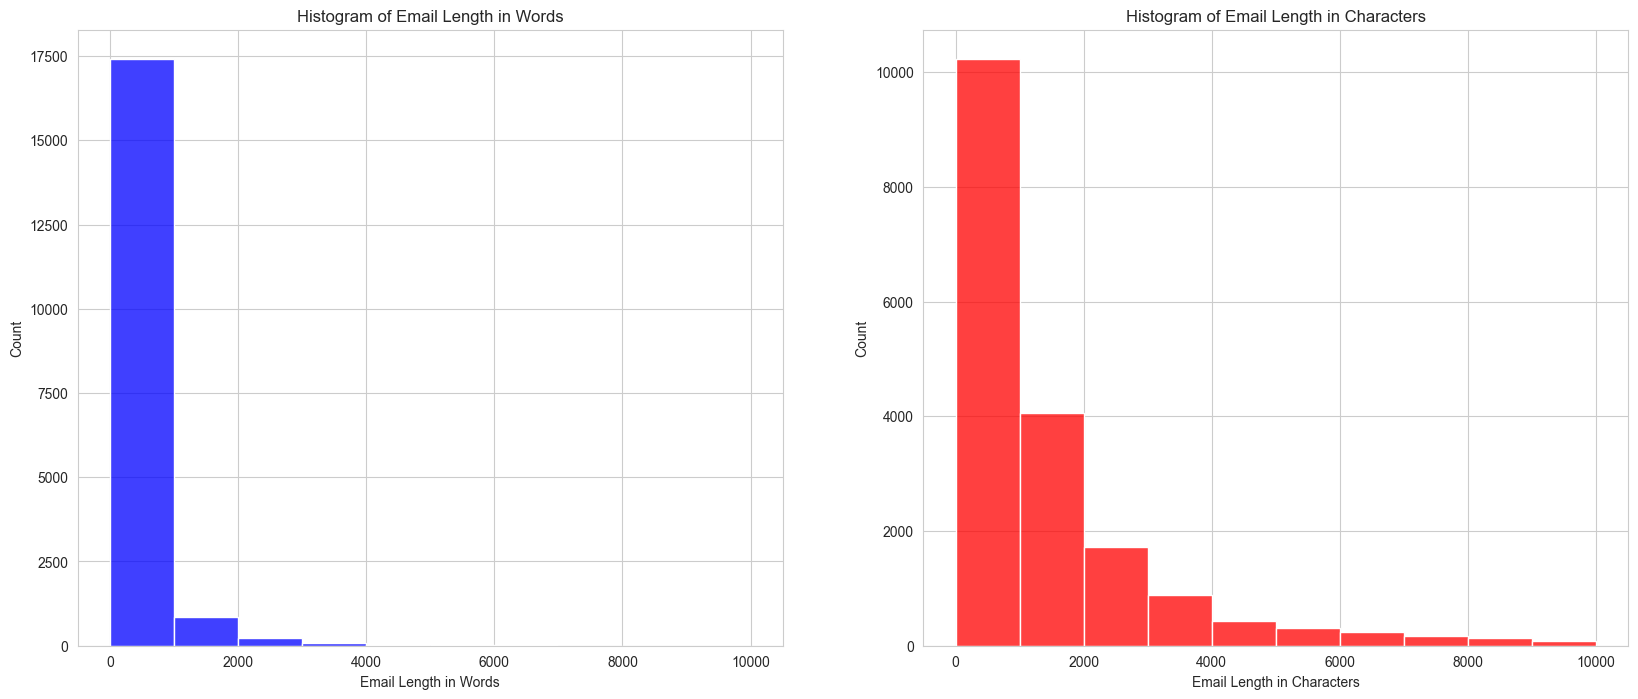

In [8]:
# Histogram of Words and Characters using seaborn
# This section creates a histogram for both 'Email Length Words' and 'Email Length Characters'
# with bins ranging from 0 to 10000, incrementing by 1000. The plot is well-documented and labeled.

import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style for seaborn plots
sns.set_style("whitegrid")

# Creating a figure and axis object
fig, ax = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns, figure size

# Plotting the histogram for 'Email Length Words'
sns.histplot(df['Email Length Words'], bins=range(0, 10001, 1000), ax=ax[0], color='blue')
ax[0].set_title('Histogram of Email Length in Words')
ax[0].set_xlabel('Email Length in Words')
ax[0].set_ylabel('Count')

# Plotting the histogram for 'Email Length Characters'
sns.histplot(df['Email Length Characters'], bins=range(0, 10001, 1000), ax=ax[1], color='red')
ax[1].set_title('Histogram of Email Length in Characters')
ax[1].set_xlabel('Email Length in Characters')
ax[1].set_ylabel('Count')

# Displaying the plot
plt.show()








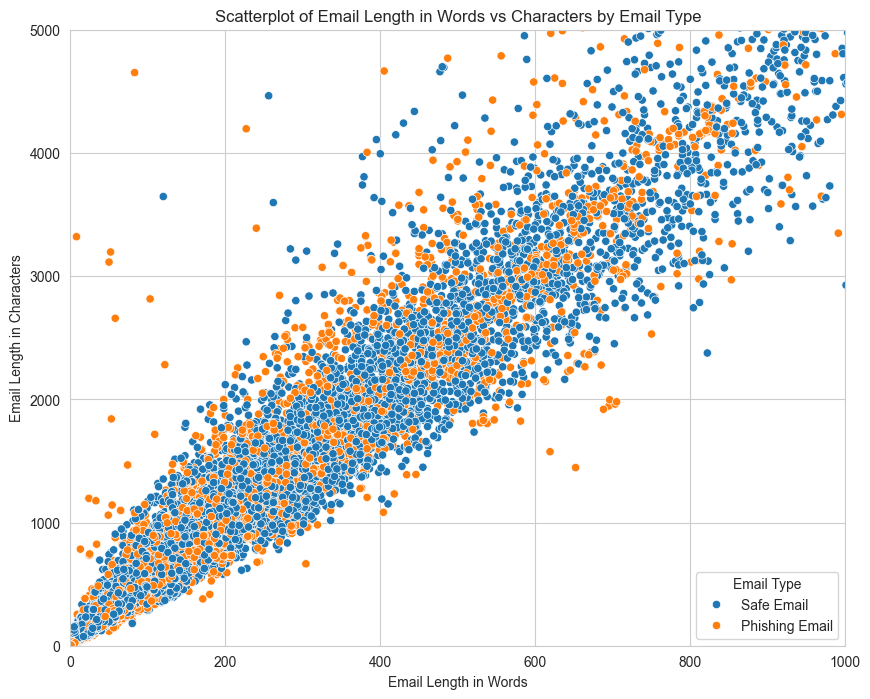

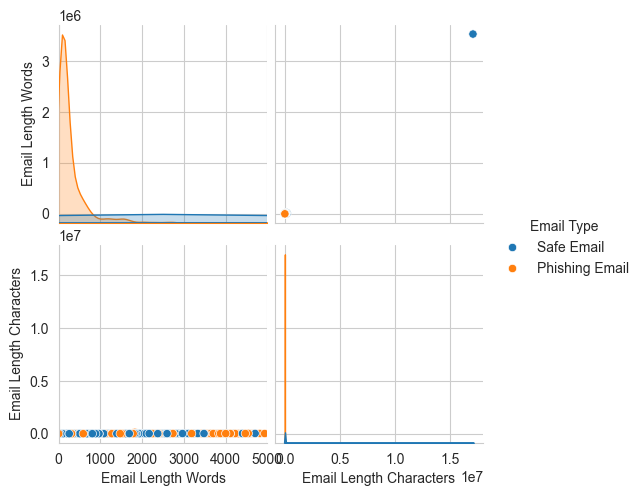

In [9]:
# Creating a scatterplot with seaborn to visualize the relationship between Email Length in Words and Characters
# with the Classification of Email Type as Hue, zooming in on the lower left part of the plot

import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style for seaborn plots
sns.set_style("whitegrid")

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(10, 8))  # Figure size

# Plotting the scatterplot
sns.scatterplot(data=df, x='Email Length Words', y='Email Length Characters', hue='Email Type', ax=ax)

# Setting title and labels
ax.set_title('Scatterplot of Email Length in Words vs Characters by Email Type')
ax.set_xlabel('Email Length in Words')
ax.set_ylabel('Email Length in Characters')

# Zooming in on the lower left part of the plot
ax.set_xlim(0, 1000)  # Limiting the x-axis to 0 to 1000
ax.set_ylim(0, 5000)  # Limiting the y-axis to 0 to 5000

# Displaying the plot
plt.show()

# Creating a pairplot with seaborn to visualize the distribution of Email Length in Words and Characters
# according to the hue of Email Type, zooming in on the left part of the plot
g = sns.pairplot(df, hue='Email Type', vars=['Email Length Words', 'Email Length Characters'])
g.axes[0,0].set_xlim(0, 1000)  # Limiting the x-axis to 0 to 1000 for the first plot
g.axes[1,0].set_xlim(0, 5000)  # Limiting the x-axis to 0 to 5000 for the second plot

# Displaying the plot
plt.show()


### LLM Classification

In [10]:
# Initialize the OpenAI client
client = instructor.patch(OpenAI())

# Define the data model for classification
class EmailCategory(str, Enum):
    SAFE = "Safe Email" 
    PHISHING = "Phishing Email" 
    # UNSURE = "Unsure, to be analysed by a human"

class EmailClassification(BaseModel):
    category: EmailCategory
    confidence: float = Field(ge=0, le=1, description="Confidence score for the classification")


In [11]:
SYSTEM_PROMPT = """
You are an AI assistant for a large customer support team. 

Your tasks:
1. Categorize the ticket into the most appropriate category.
2. Provide a confidence score for the classification.

Remember:
- Be objective and base your analysis solely on the information provided in the ticket.
- If you're unsure about any aspect, reflect that in your confidence score.

Analyze the following customer support ticket and provide the requested information in the specified format.
"""

def classify_ticket(ticket_text: str) -> EmailClassification:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        response_model=EmailClassification,
        temperature=0,
        max_retries=3,
        messages=[
            {
                "role": "system",
                "content": SYSTEM_PROMPT,
            },
            {"role": "user", "content": ticket_text}
        ]
    )
    return response

In [12]:
sub_set = df.iloc[:1000, :]

In [13]:
# Ensure that the 'Email Text' column is a string
sub_set['Email Text'] = sub_set['Email Text'].astype(str)


C:\Users\Caleb\AppData\Local\Temp\ipykernel_22124\3516135145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_set['Email Text'] = sub_set['Email Text'].astype(str)


In [14]:

# Classify each entry in the new 'article' column
sub_set['Classification'] = sub_set['Email Text'].apply(classify_ticket)



C:\Users\Caleb\AppData\Local\Temp\ipykernel_22124\2637064539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_set['Classification'] = sub_set['Email Text'].apply(classify_ticket)


In [15]:
sub_set

,Unnamed: 0,Email Text,Email Type,Email Length Words,Email Length Characters,Classification
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230,1030,category=<EmailCategory.SAFE: 'Safe Email'> co...
1,1,the other side of * galicismos * * galicismo *...,Safe Email,91,479,category=<EmailCategory.SAFE: 'Safe Email'> co...
2,2,re : equistar deal tickets are you still avail...,Safe Email,305,1245,category=<EmailCategory.SAFE: 'Safe Email'> co...
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,96,688,category=<EmailCategory.PHISHING: 'Phishing Em...
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,91,441,category=<EmailCategory.PHISHING: 'Phishing Em...
...,...,...,...,...,...,...
995,995,"summary : "" grasshopper mind "" short answer : ...",Safe Email,945,4943,category=<EmailCategory.SAFE: 'Safe Email'> co...
996,996,value meds at affordable prices new overnight ...,Phishing Email,173,966,category=<EmailCategory.PHISHING: 'Phishing Em...
997,997,cultural identities = = = = = = = = = = = = = ...,Safe Email,1318,6729,category=<EmailCategory.SAFE: 'Safe Email'> co...
998,998,schedulec - dailyo 301 . xls the enclosed file...,Safe Email,23,113,category=<EmailCategory.SAFE: 'Safe Email'> co...


Observations with confidence above 0.9: 100
Observations with confidence between 0.6 and 0.9: 861
Observations with confidence below 0.6: 39


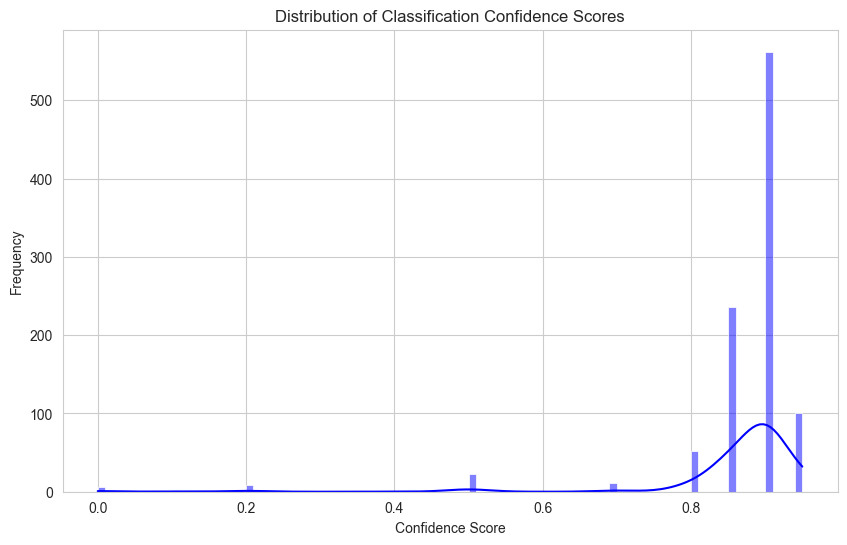

In [16]:
# Assuming 'Classification' is a column containing LanguageClassification objects
# Extract the confidence scores from the Classification column
confidence_scores = sub_set['Classification'].apply(lambda x: x.confidence)

# Count observations based on confidence levels
above_0_9 = (confidence_scores > 0.9).sum()
between_0_6_and_0_9 = ((confidence_scores >= 0.6) & (confidence_scores <= 0.9)).sum()
below_0_6 = (confidence_scores < 0.6).sum()

# Print the results
print(f"Observations with confidence above 0.9: {above_0_9}")
print(f"Observations with confidence between 0.6 and 0.9: {between_0_6_and_0_9}")
print(f"Observations with confidence below 0.6: {below_0_6}")

# Plotting the distribution of confidence scores using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the distribution of confidence scores
sns.histplot(confidence_scores, kde=True, ax=ax, color='blue')

# Setting the title and labels
ax.set_title('Distribution of Classification Confidence Scores')
ax.set_xlabel('Confidence Score')
ax.set_ylabel('Frequency')

# Displaying the plot
plt.show()



In [17]:
# Assuming EmailCategory is already defined as shown
from enum import Enum


# Define a mapping function using the EmailCategory enum
def map_classification(classification):
    # Access the category attribute
    category = classification.category
    if category == EmailCategory.SAFE:
        return EmailCategory.SAFE.value
    elif category == EmailCategory.PHISHING:
        return EmailCategory.PHISHING.value
    else:
        return 'Other'  # For UNSURE or any other unexpected categories

# Create a new column 'Email Classification' based on the mapping
sub_set['Email Classification'] = sub_set['Classification'].apply(map_classification)




C:\Users\Caleb\AppData\Local\Temp\ipykernel_22124\4093559496.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_set['Email Classification'] = sub_set['Classification'].apply(map_classification)


In [18]:
sub_set['Email Classification'].value_counts()


Email Classification
Safe Email        633
Phishing Email    367
Name: count, dtype: int64

In [19]:
sub_set[['Email Text', 'Email Type', 'Classification', 'Email Classification']]

,Email Text,Email Type,Classification,Email Classification
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,category=<EmailCategory.SAFE: 'Safe Email'> co...,Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email,category=<EmailCategory.SAFE: 'Safe Email'> co...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email,category=<EmailCategory.SAFE: 'Safe Email'> co...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,category=<EmailCategory.PHISHING: 'Phishing Em...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email,category=<EmailCategory.PHISHING: 'Phishing Em...,Phishing Email
...,...,...,...,...
995,"summary : "" grasshopper mind "" short answer : ...",Safe Email,category=<EmailCategory.SAFE: 'Safe Email'> co...,Safe Email
996,value meds at affordable prices new overnight ...,Phishing Email,category=<EmailCategory.PHISHING: 'Phishing Em...,Phishing Email
997,cultural identities = = = = = = = = = = = = = ...,Safe Email,category=<EmailCategory.SAFE: 'Safe Email'> co...,Safe Email
998,schedulec - dailyo 301 . xls the enclosed file...,Safe Email,category=<EmailCategory.SAFE: 'Safe Email'> co...,Safe Email


In [20]:
sub_set[['Email Text', 'Email Type', 'Classification', 'Email Classification']]
print("Accuracy: ", (sub_set['Email Classification'] == sub_set['Email Type']).mean())

Accuracy:  0.937


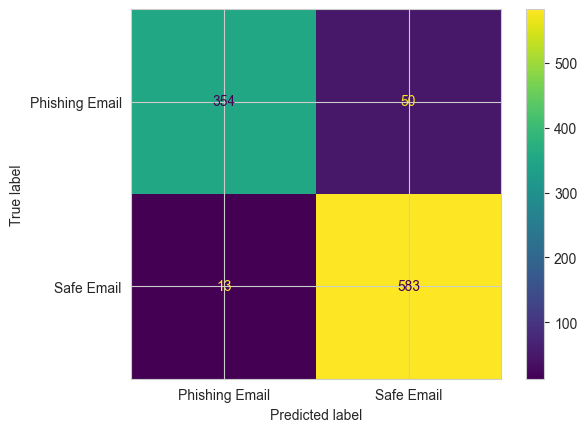

In [21]:
# Show a confusion matrix of our binary classification
# The real Y is Email Type, and the predicted Y is Email Classification


from sklearn.metrics import confusion_matrix
confusion_matrix(sub_set['Email Type'], sub_set['Email Classification'])

# Have a plot or visualization of the confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(sub_set['Email Type'], sub_set['Email Classification'])

